Importons dans un premier temps l'ensemble des librairies utiles :

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import norm

# Q1
 *Tracer le prix de l’option d’achat à barrière up-and-out discrète en fonction de S0
(comparer avec le call standard)*

**Réponse :** Nous choisissons par défaut les paramètres ci-dessous :

In [ ]:
r = 0.03
K = 100
S0 = 100
sigma = 0.2
T = 1
S= np.arange(10,300)
barrier = 200
n = 100 #nombre de pas
N = 5000 #nombre de simulations

On consière une option d'achat barrière up-and-out discrète sur le sous-jacent $\mathrm{S}$, de strike $\mathrm{K}$, de barrière $\mathrm{M}$ et de maturité $\mathrm{T}$, évaluée à N dates d'observations.

Le payoff associé est :  $H(t, S_t)=\left(S_T-K\right)_{+} 1_{\max \left(S_{t_1}, \ldots \ldots S_{t_N}\right)<M}$, où $\left(t_1, \ldots, t_N\right)$ sont $\mathrm{N}$ dates dans l'intervalle $] 0, T]$, tel que si le prix du sous-jacent dépasse la barrière à l'une des dates, le payoff à maturité est nul.  

Pour tracer le prix de l'option, on considère le modèle de BS: $\forall \mathrm{t} \geq 0, S_t=S_0 e^{\left(r -\frac{\sigma^2}{2}\right) t+\sigma \mathrm{B_t}}$ on réalise une méthode de Monte Carlo avec une simulation pas à pas, telle que : 
$$
 \forall i \in\{1, \ldots, \mathrm{N}\},
S_{t_i}=S_{t_{i-1}} e^{\left(r-\frac{\sigma^2}{2}\right)\left(t_i-t_{i-1}\right)+\sigma\left(B_{t_i}-B_{t_{i-1}}\right)} .
$$

In [ ]:
#Définissons d'abord le call standard :
def d1_(S, K, r, sigma, T, t):
    return (np.log(S/K) + (r + 0.5 * sigma**2)*(T-t))/(sigma*np.sqrt(T-t))

def call_standard(S, K, r, sigma, T, t):
    d1 = d1_(S, K, r, sigma, T, t)
    d2 = d1 - sigma * np.sqrt(T-t)
    return S * norm.cdf(d1) - K * np.exp(-r*(T-t))*norm.cdf(d2)

#On construit le call à barrière up and out en simulant s pas à pas :
def call_barriere_up_and_out(S0, K, r, sigma, n, N, T, barrier):
  S = np.zeros((n+1, N))
  trig = np.ones(N)
  S[0,:] = S0 * np.ones(N)
  for i in range(1,n+1):
    S[i,:] = S[i-1,:] * (np.exp((r-(np.square(sigma)/2))* T/n +
                            sigma*np.random.normal(size=N, scale=np.sqrt(T/n))))
  price_sample = np.exp(-r*T) * np.maximum(0, S[-1,:] - K) * np.where(np.max(S[1:,:], axis=0)<barrier,1,0)
  return price_sample

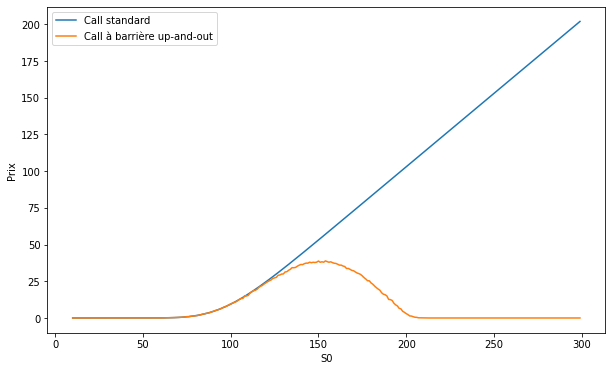

In [ ]:
#Visualisons les prix de l'option standard et à barrière suivant S_0 : 

plt.figure(figsize = ((10,6)))
call_barriere_list = [np.mean(call_barriere_up_and_out(s, K, r, sigma, n, N, T,barrier)) for s in S]
call_standard_list = call_standard(S, K, r, sigma, T, 0)
plt.plot(S, call_standard_list, label='Call standard')
plt.plot(S, call_barriere_list, label='Call à barrière up-and-out')
plt.xlabel('S0')
plt.ylabel("Prix")
plt.legend()
plt.show()

Le prix d'une option barrière up-and-out est proche de celui du call standard pour des valeurs de S0<<barrier, il augmente jusqu'à S0 égale à 150, puis diminue et s'annule à partir de S0>barrier. Cela est bien en accord avec la définition précedemment faite de l'option barrière up-and-out

# 2. 
*Tracer l’évolution du prix de l’option d’achat à barrière up-and-out discrète quand le
nombre de dates d’observation augmente. Vérifier la convergence vers le prix avec
monitoring continu de la barrière.*


 Traçons d'abord l’évolution du prix de l’option d’achat à barrière up-and-out discrète quand le nombre de dates d’observation augmente. Pour cela modifions le paramètre n de la fonction call_barriere :

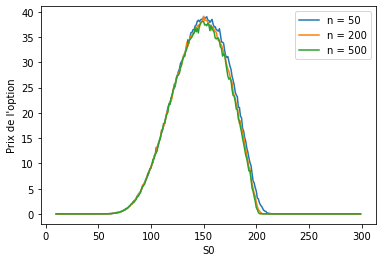

In [ ]:
# traçons l'évolution du prix de l'option pour n=50, n=200 et n=500 
cb_50 = [np.mean(call_barriere_up_and_out(s, K, r, sigma, 50, N, T,barrier)) for s in S]
cb_200 = [np.mean(call_barriere_up_and_out(s, K, r, sigma, 200, N, T,barrier)) for s in S]
cb_500 = [np.mean(call_barriere_up_and_out(s, K, r, sigma, 500, N, T,barrier)) for s in S]
plt.plot(S, cb_50, label='n = 50')
plt.plot(S, cb_200, label='n = 200')
plt.plot(S, cb_500, label='n = 500')
plt.xlabel('S0')
plt.ylabel("Prix de l'option")
plt.legend()
plt.show()

**Réponse :**
Ensuite, On peut déterminer le prix d’une option up-and-out sans passer par une discrétisation temporelle en s'aidant du maximum courant du processus $S_t$. 

En effet, on peut réécrire : 
$ S_t=S_0 e^{\left(r -\frac{\sigma^2}{2}\right) t+\sigma \mathrm{B_t}}=S_0 e^{\sigma\left[\left(\frac{r}{\sigma} -\frac{\sigma}{2}\right )   t+B_t\right]}=S_0 e^{\sigma X_t}  $

$\text { avec } X_t=\alpha t +B_t,  \alpha=\left(\frac{r}{\sigma}-\frac{\sigma}{2}\right)$


Ainsi, on peut simuler le maximum conditionnel du processus $X$, $M_t^X$ et on obtiendra celui de S par la relation $M_t^S = S_0e^{\sigma M_t^X}$. 

On fera alors varier le nombre de dates d'observation pour visualiser la convergence vers le prix avec monitoring continu de la barrière.  

In [ ]:
def MC_continu(S0, K, r, sigma, T, N, barrier):
  ST = S0*np.exp((r-np.square(sigma)/2)*T + np.random.normal(size=N)*sigma*np.sqrt(T))
  XT = 1/sigma * np.log(ST/S0)
  u = np.random.uniform(0, 1, 1000)
  # on construit d'abord la variable maximum conditionnel de Xt
  MxT = np.zeros((len(XT), len(u)))
  for i in range(len(u)):
    MxT[:,i] = (XT + np.sqrt(np.square(XT) - 2*T*np.log(u[i])))/2
  #on construit ensuite la variable maximum conditionnel du sous-jacent
  MsT = S0 * np.exp(sigma * MxT)
  prix = np.exp(-r*T) * np.maximum(0, ST - K) * np.where(np.mean(MsT, axis=1) < barrier,1,0)
  return np.mean(prix)

#On se place à S0=170 pour visualiser une zone à forte variation 
S0=170
n_list = np.arange(50,600,5)
upandout_price_list = []
for n in n_list:
  upandout_price_list.append(np.mean(call_barriere_up_and_out(S0, K, r, sigma, n, N, T,barrier)))

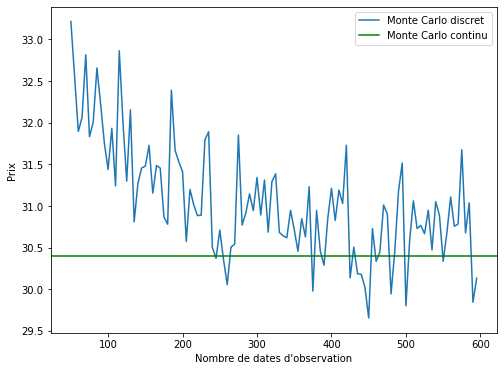

In [ ]:
plt.figure(figsize = ((8,6)))
plt.plot(n_list, upandout_price_list, label= 'Monte Carlo discret')
plt.xlabel("Nombre de dates d'observation")
plt.ylabel("Prix")
prix_continu = MC_continu(S0, K, r, sigma, T, N, barrier)
plt.axhline(y= prix_continu, color='g', label='Monte Carlo continu')
plt.legend()
plt.show()

Cela permet bien d'illuster la convergence vers la solution continu par augmentation du nombre de dates d'observations.

# Q3
*Tracer le prix de l’option d’achat à barrière down-and-in.*

L'option d’achat down-and-in sur un sous-jacent S, de strike K, de barrière M et de maturité T, évaluée à N dates d'observations a pour payoff : $𝐻(𝑡,𝑆_t)=(𝑆_T−𝐾)_+1_{𝑚𝑖𝑛(S_{𝑡_1},......,𝑆_{𝑡_𝑁})<𝑀}$

Traçons l’évolution du prix de l’option down-and-in en fonction de $S_0$ par une méthode de Monte Carlo :



In [ ]:
def call_barriere_down_and_in(S0, K, r, sigma, n, N, T, barrier):
  S = np.zeros((n+1, N))
  S[0,:] = S0 * np.ones(N)
  for i in range(1,n+1):
    S[i,:] = S[i-1,:] * (np.exp((r-(np.square(sigma)/2))* T/n + sigma*np.random.normal(size=N, scale=np.sqrt(T/n))))
  price_sample = np.exp(-r*T) * np.maximum(0, S[-1,:] - K) * np.where(np.min(S[1:,:], axis=0)<barrier,1,0)
  return price_sample

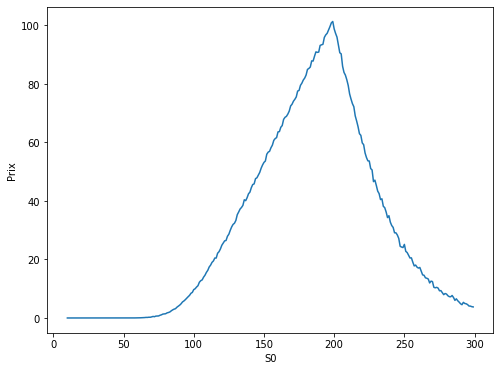

In [ ]:
plt.figure(figsize = ((8,6)))
prix = [np.mean(call_barriere_down_and_in(s, K, r, sigma, n,N, T,barrier)) for s in S]
plt.plot(S, prix)
plt.xlabel('S0')
plt.ylabel("Prix")
plt.show()

Nous constatons que le coût de l'option down-and-in atteint des niveaux plus élevés que celui d'une option up-and-out présentant des paramètres similaires. Le prix baisse pour S supérieur à M &gt; 200, mais ne s'annule pas.

# Q4
Analyser la réduction de variance de l’estimateur de Monte Carlo obtenue avec une
méthode de type Monte Carlo conditionnel.

**Réponse :**
Cette méthode de réduction de variance s'appuie sur le fait que le prix de l’option connu à travers la formule de BS au moment où le sous-jacent a une valeur inférieure à la barrière M.

In [ ]:
def standard_variance(S0, K, r, sigma, n, N, T, barrier):
  S = np.zeros((n+1, N))
  S[0,:] = S0 * np.ones(N)
  for i in range(1,n+1):
    S[i,:] = S[i-1,:] * (np.exp((r-(np.square(sigma)/2))* T/n + sigma*np.random.normal(size=N, scale=np.sqrt(T/n))))
  prix = np.exp(-r*T) * np.maximum(0, S[-1,:] - K) * np.where(np.min(S[1:,:], axis=0)<barrier,1,0)
  prix_var = (1/(N - 1)) * np.sum(np.square(prix - np.mean(prix)))
  estimator_var = prix_var / N
  return estimator_var

In [ ]:
def Monte_Carlo_conditionnel(S0, K, r, sigma, T, N, barrier):
  S = np.zeros((n+1, N))
  S[0,:] = S0 * np.ones(N)
  prix = np.zeros(N)
  trigger = np.ones(N)
  for j in range(N):
    for i in range(1,n+1):
      S[i,j] = S[i-1,j] * (np.exp((r-(np.square(sigma)/2))* T/n + sigma*np.random.normal(scale=np.sqrt(T/n))))
      if S[i, j] < barrier:
        prix[j] =  call_standard(S[i, j], K, r, sigma, T, i/n*T)
        trigger[j] = 0
        break
  prix = np.exp(-r*T) * np.maximum(0, S[-1,:] - K) * np.where(np.min(S[1:,:], axis=0)<barrier,1,0)
  prix_var = (1/(N - 1)) * np.sum(np.square(prix - np.mean(prix)))
  estimator_var = prix_var / N
  return prix_var

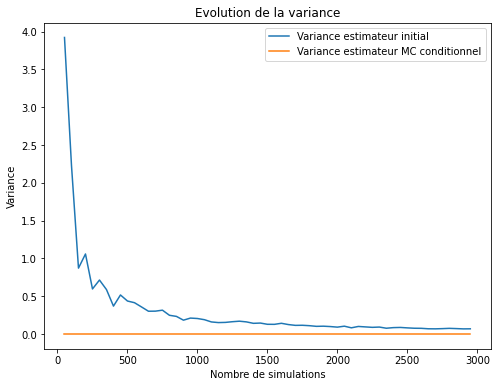

In [ ]:
plt.figure(figsize = ((8,6)))
N_list = np.arange(50,3000,50)
barrier = 200
S0 = 100
standard_list = [standard_variance(S0, K, r, sigma, n, N, T, barrier) for N in N_list]
conditional_mc_list = [Monte_Carlo_conditionnel(S0, K, r, sigma, T, N, barrier) for N in N_list]
plt.plot(N_list, standard_list, label= 'Variance estimateur initial')
plt.plot(N_list, conditional_mc_list, label= 'Variance estimateur MC conditionnel')
plt.xlabel("Nombre de simulations")
plt.ylabel("Variance")
plt.title("Evolution de la variance")
plt.legend()
plt.show()

# Q5
*Tracer la somme du prix du call up-and-in et du call up-and-out. Interpréter.*

**Réponse :** 

In [ ]:
#On construit le call à barrière up and in en simulant s pas à pas :
def call_barriere_up_and_in(S0, K, r, sigma, n, N, T, barrier):
  S = np.zeros((n+1, N))
  trig = np.ones(N)
  S[0,:] = S0 * np.ones(N)
  for i in range(1,n+1):
    S[i,:] = S[i-1,:] * (np.exp((r-(np.square(sigma)/2))* T/n +
                            sigma*np.random.normal(size=N, scale=np.sqrt(T/n))))
  price_sample = np.exp(-r*T) * np.maximum(0, S[-1,:] - K) * np.where(np.max(S[1:,:], axis=0)>barrier,1,0)
  return price_sample

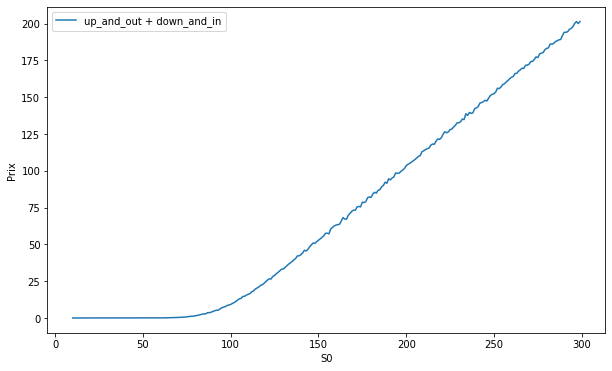

In [ ]:
plt.figure(figsize = ((10,6)))
prix_up_and_out = [np.mean(call_barriere_up_and_out(s, K, r, sigma, n, N, T,barrier)) for s in S]
prix_up_and_in = [np.mean(call_barriere_up_and_in(s, K, r, sigma, n,N, T,barrier)) for s in S]
prix=[sum(x) for x in zip(prix_up_and_out, prix_up_and_in)]
plt.plot(S, prix, label='up_and_out + down_and_in')
plt.xlabel('S0')
plt.ylabel("Prix")
plt.legend()
plt.show()

Pour un niveau de barrier identique, si le sous-jacent augmente trop fortement, le Call up-and-out disparaîtrait et le Call up-and-in s’activerait,  cela est équivalent à posséder un Call. 

**Rayan Takka**